# Model training and prediction - `composite`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import pandas as pd

In [5]:
X_train = pd.read_csv("./data/processed/composite/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/composite/y_train.csv", index_col = 0).composite
X_test = pd.read_csv("./data/processed/composite/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/composite/y_test.csv", index_col = 0).composite
tc_test = pd.read_csv("./data/processed/s30d/tc_test.csv", index_col = 0).tc

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0    98.167497
1     1.832503
Name: composite, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [8]:
import random
import numpy as np
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [9]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:1]
}

In [12]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [13]:
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    lr,
    rf
]

In [14]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [15]:
from src.models.classifiers import StackedGeneralizationClassifier

In [16]:
sgclf = StackedGeneralizationClassifier(
    base_clfs=base_clfs, 
    meta_clf=LogisticRegression(),
    use_probas=True, 
    verbose=False
)
sgclf.cv_outer_loop(
    all_hyper_parameters=all_hyper_parameters,
    X=X_train, 
    y=y_train, 
    refit=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

Outer loop, each fold:
	Number of 0's: ~3054 (98.17%)
	Number of 1's: ~57 (1.83%)
Inner loop, each loop:
	Number of 0's: ~1527 (98.17%)
	Number of 1's: ~28 (1.83%)


In [17]:
y_test_pred_con, y_test_pred_cut = sgclf.predict(X_test)

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
("Hold-out AUC of ROC, continous model: " + 
str(roc_auc_score(y_score = y_test_pred_con, y_true = y_test)))

'Hold-out AUC of ROC, continous model: 0.6585668493433978'

In [20]:
("Hold-out AUC of ROC, cut model: " + 
str(roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)))

'Hold-out AUC of ROC, cut model: 0.5'

In [21]:
from src.visualization.visualize import plot_roc, plot_precision_recall

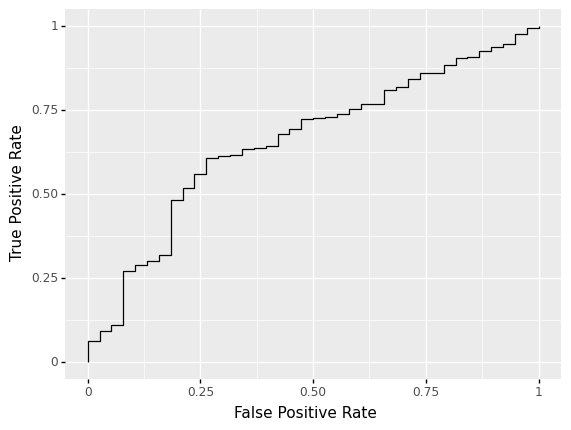

<ggplot: (371887522)>

In [22]:
plot_roc(y_test, y_test_pred_con)

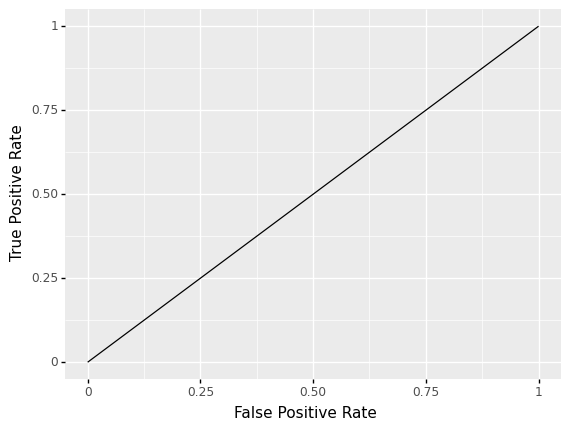

<ggplot: (326071732)>

In [23]:
plot_roc(y_test, y_test_pred_cut)

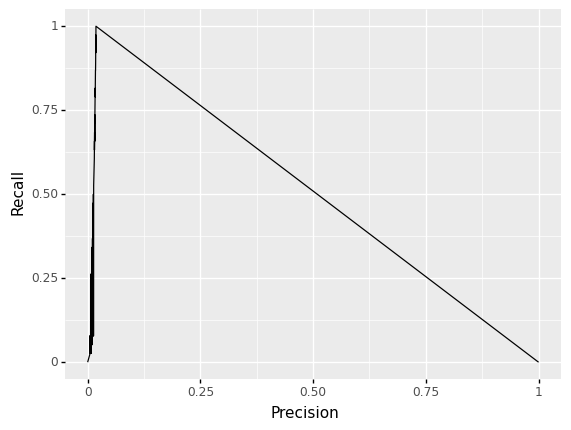

<ggplot: (372023651)>

In [24]:
plot_precision_recall(y_test, y_test_pred_con)

Plot roc curves for each classifier

In [25]:
from src.visualization.visualize import plot_roc_base_clfs

In [26]:
y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False)

In [27]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score
)

In [28]:
y_pred_meta_clf = sgclf.predict(X_test, use_probas = False)

In [29]:
y_test_pred_clfs = np.column_stack((y_test_pred_clfs, y_pred_meta_clf))
y_test_prob_clfs = np.column_stack((y_test_prob_clfs, y_test_pred_con))

In [30]:
def compute_performance(y_prob, y_pred, y_true):
    roc_auc = roc_auc_score(
        y_true=y_true, 
        y_score=y_prob
    )
    prec = precision_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average="macro"
    )
    rec = recall_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average="macro"
    )
    return dict(roc_auc = roc_auc, prec = prec, rec = rec)

def compile_performance(y_probs: pd.DataFrame, y_preds: pd.DataFrame,
                        y_true: np.array, tc: np.array, keys: list):
    ds = [
        compute_performance(y_prob=prob, y_pred=pred, y_true=y_true) 
        for prob, pred in zip(y_probs.T, y_preds.T)
    ]
    nri_metrics = ["nri", "nri_plus", "nri_minus"]

    
    return pd.DataFrame(ds, index = keys)

In [31]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

In [32]:
compile_performance(
    y_preds=y_test_pred_clfs, 
    y_probs=y_test_prob_clfs, 
    y_true=y_test, 
    tc=tc_test,
    keys=keys + [sgclf.__class__.__name__]
)

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,roc_auc,prec,rec
LogisticRegression,0.652750,0.490839,0.5
RandomForestClassifier,0.631139,0.490839,0.5
StackedGeneralizationClassifier,0.658567,0.490839,0.5


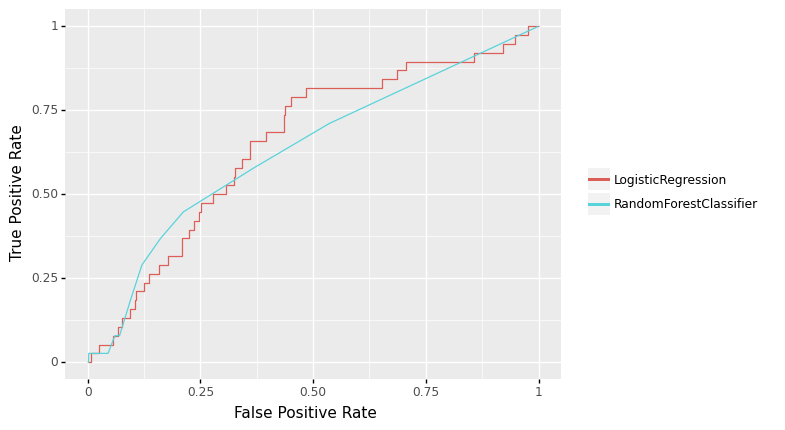

<ggplot: (371942542)>

In [33]:
plot_roc_base_clfs(y_test_prob_clfs, y_test, keys)

In [34]:
from src.models.metrics import calculate_nri

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [35]:
nri = calculate_nri(
    y_true=y_test.to_numpy(), 
    y_old=tc_test.to_numpy(), 
    y_new=y_test_pred_cut
) 

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



                 Estimate
NRI           -0.06240306
NRI+          -0.18421053
NRI-           0.12180747
Pr(Up|Case)    0.00000000
Pr(Down|Case)  0.18421053
Pr(Down|Ctrl)  0.12180747
Pr(Up|Ctrl)    0.00000000


In [36]:
nri

nri            -0.062403
nri_plus       -0.184211
nri_minus       0.121807
pr_up_dead      0.000000
pr_down_dead    0.184211
pr_down_surv    0.121807
pr_up_surv      0.000000
dtype: float64